# PIMA Model using PYCaret 1.0

In [6]:
import pandas as pd

In [ ]:
#loading the data 

In [7]:
dataset=pd.read_csv('datasets_228_482_diabetes.csv')

In [8]:
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [10]:
dataset.shape # we have  768 rows and 9 data columns  


(768, 9)

# EDA 

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import squarify


In [37]:
Diabetic = dataset[(dataset['Outcome'] != 0)]
Non_diabetic = dataset[(dataset['Outcome'] == 0)]


def target_count():
    trace = go.Bar( x = dataset['Outcome'].value_counts().values.tolist(), 
                    y = ['Non_diabetic','diabetic' ], 
                    orientation = 'h', 
                    text=dataset['Outcome'].value_counts().values.tolist(), 
                    textfont=dict(size=15),
                    textposition = 'auto',
                    opacity = 0.8,marker=dict(
                    color=['lightskyblue', 'gold'],
                    line=dict(color='#000000',width=1.5)))

    layout = dict(title =  'Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)



In [38]:
target_count()


Dataset is clearly unbalanced we can use SMOTE sampling to balance the classes. But In this notebook we are not going to look at it. 

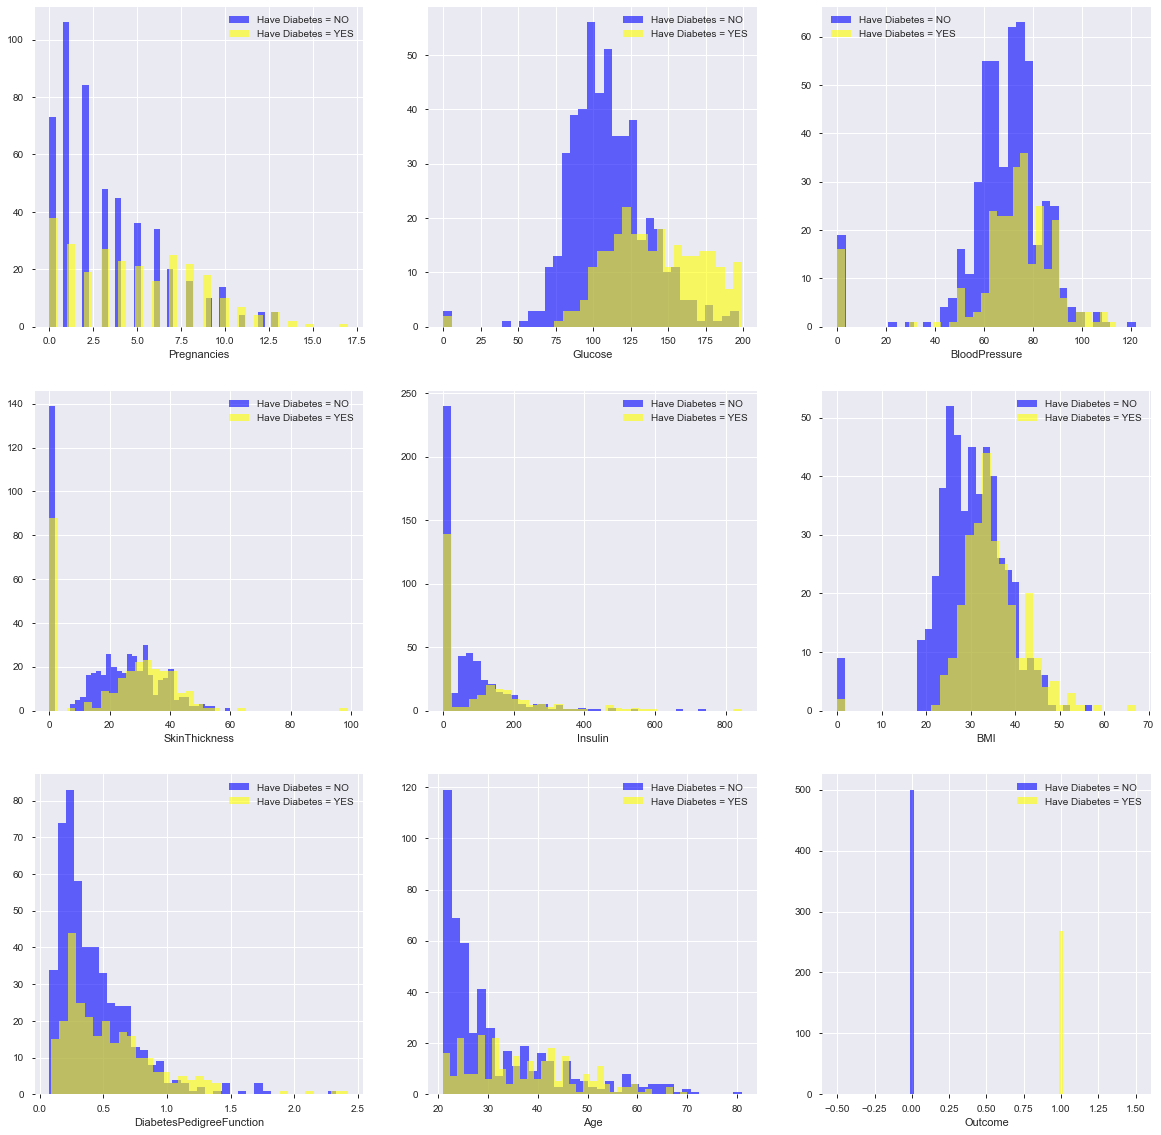

In [41]:
# Visulazing the distibution of the data for every feature
plt.figure(figsize=(20, 20))

for i, column in enumerate(dataset.columns, 1):
    plt.subplot(3, 3, i)
    dataset[dataset["Outcome"] == 0][column].hist(bins=35, color='blue', label='Have Diabetes = NO', alpha=0.6)
    dataset[dataset["Outcome"] == 1][column].hist(bins=35, color='yellow', label='Have Diabetes = YES', alpha=0.6)
    plt.legend()
    plt.xlabel(column)

Before doing anything the first thing we need to do is splitting data into training set and validation set. 
1)	Training set : - Data set on which we build the model  and fine tune the model. 
2)	Validation set: - Data set on which we test how well our finalized model is performing. It is important that during the modelling stage we don’t expose this data for our model. This should be unseen instance for our model.


In [42]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index).reset_index(drop=True)
data.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

Data for Modeling: (730, 9)
Unseen Data For Predictions (38, 9)


I have 730 data points to model and 38 data points to test my model. 

In [43]:
from pycaret.classification import *

Setup function in PyCaret is the most important function this is where we perform all our data preprocessing steps. 
•	Data = Data for modelling 
•	Target = Target column that we want to predict in this case it is diabetic or not 
•	Session_id  = User defined session id 
•	Normalization =  Machine learning models work well when the input features do not have huge variation such as BMI and  Glucose their values are on different scale. It is important to scale then hence we use normalize parameter 
•	Transformation = While normalization reduces the variance transformation changes the data so that It could be represented in Gaussian distribution (normal curve).
•	Multicollinearity: - When the data  is highly co-related our algorithms tend not to generalize very well so it is important to remove multi- collinearity by using the remove_multicollinearity  and multicollinearity_threshold parameters in setup
•	Sometimes a dataset may have a categorical feature with multiple levels, where distribution of such levels are skewed and one level may dominate over other levels. This means there is not much variation in the information provided by such feature.  For a ML model, such feature may not add a lot of information and thus can be ignored for modeling. This can be achieved in PyCaret using ignore_low_variance parameter 


In [44]:
clf = setup(data = data, target = 'Outcome',session_id=1229,normalize=True,transformation=True,ignore_low_variance=True,
           remove_multicollinearity=True, multicollinearity_threshold=0.95)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,1229
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(730, 9)"
4,Missing Values,False
5,Numeric Features,7
6,Categorical Features,1
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Before you proceed Make sure all your data types are inferred correctly If so press enter if not change the data types. You can find more info about data types that on this page https://pycaret.org/data-types/

In [49]:
compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Extreme Gradient Boosting,0.7471,0.8286,0.5922,0.6589,0.6168,0.4297
1,Gradient Boosting Classifier,0.751,0.826,0.5859,0.6737,0.6134,0.433
2,CatBoost Classifier,0.7745,0.8227,0.6101,0.7165,0.6546,0.4886
3,Logistic Regression,0.7451,0.8145,0.5605,0.6661,0.605,0.4192
4,Linear Discriminant Analysis,0.7392,0.811,0.5546,0.6513,0.5951,0.4053
5,Extra Trees Classifier,0.7431,0.8087,0.4977,0.6888,0.5718,0.3958
6,Light Gradient Boosting Machine,0.7314,0.8031,0.5477,0.6418,0.5852,0.3887
7,Ada Boost Classifier,0.7392,0.7952,0.5536,0.6519,0.5954,0.4052
8,Random Forest Classifier,0.7275,0.7703,0.4618,0.6573,0.5346,0.3522
9,K Neighbors Classifier,0.7157,0.7637,0.5297,0.6222,0.5597,0.354


In [83]:
catboost = create_model('catboost',fold =10) #CatBoost Classifier

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8039,0.8426,0.5882,0.7692,0.6667,0.5312
1,0.8431,0.8651,0.5882,0.9091,0.7143,0.6129
2,0.8039,0.8443,0.6471,0.7333,0.6875,0.5455
3,0.7647,0.8586,0.6667,0.6667,0.6667,0.4848
4,0.7843,0.7845,0.6667,0.7059,0.6857,0.5217
5,0.8039,0.8485,0.5556,0.8333,0.6667,0.5355
6,0.6863,0.7424,0.5556,0.5556,0.5556,0.3131
7,0.7255,0.8081,0.6111,0.6111,0.6111,0.3990
8,0.7647,0.8249,0.5556,0.7143,0.6250,0.4574
9,0.7647,0.8081,0.6667,0.6667,0.6667,0.4848


In [85]:
tuned_cat_boost= tune_model('catboost', optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7647,0.8806,0.5294,0.6923,0.6000,0.4375
1,0.8431,0.8910,0.5882,0.9091,0.7143,0.6129
2,0.8235,0.8720,0.5882,0.8333,0.6897,0.5714
3,0.8039,0.8956,0.6111,0.7857,0.6875,0.5479
4,0.7255,0.7744,0.6111,0.6111,0.6111,0.3990
5,0.7451,0.8266,0.4444,0.7273,0.5517,0.3878
6,0.5882,0.7037,0.3889,0.4118,0.4000,0.0870
7,0.7647,0.8283,0.5556,0.7143,0.6250,0.4574
8,0.6471,0.8030,0.3333,0.5000,0.4000,0.1639
9,0.7451,0.7946,0.6111,0.6471,0.6286,0.4348


Well we have improved from 82.27 tp 82.70 

In [86]:
#Lets Create  more classifiers 

In [88]:
lr = create_model('lr', fold =10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8235,0.8685,0.6471,0.7857,0.7097,0.5846
1,0.8235,0.8858,0.5882,0.8333,0.6897,0.5714
2,0.7843,0.8772,0.6471,0.6875,0.6667,0.5075
3,0.7255,0.8283,0.5556,0.6250,0.5882,0.3834
4,0.7059,0.7290,0.5556,0.5882,0.5714,0.3478
5,0.7451,0.8098,0.4444,0.7273,0.5517,0.3878
6,0.6078,0.7020,0.4444,0.4444,0.4444,0.1414
7,0.7255,0.7744,0.5000,0.6429,0.5625,0.3670
8,0.7255,0.8098,0.5000,0.6429,0.5625,0.3670
9,0.7843,0.8603,0.7222,0.6842,0.7027,0.5337


In [89]:
tuned_lr= tune_model('lr',optimize='AUC') # tuned_logistic   81.6 AUC

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8235,0.8702,0.6471,0.7857,0.7097,0.5846
1,0.8235,0.8858,0.5882,0.8333,0.6897,0.5714
2,0.8039,0.8841,0.6471,0.7333,0.6875,0.5455
3,0.7255,0.8367,0.5556,0.6250,0.5882,0.3834
4,0.7059,0.7290,0.5556,0.5882,0.5714,0.3478
5,0.7255,0.8098,0.4444,0.6667,0.5333,0.3497
6,0.6078,0.7037,0.4444,0.4444,0.4444,0.1414
7,0.7255,0.7778,0.5000,0.6429,0.5625,0.3670
8,0.7255,0.8081,0.5000,0.6429,0.5625,0.3670
9,0.7843,0.8586,0.7222,0.6842,0.7027,0.5337


In [91]:
gbc= create_model('gbc',fold =10) #  Gradient boosting  82.60

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7451,0.8356,0.4118,0.7000,0.5185,0.3607
1,0.7647,0.8339,0.3529,0.8571,0.5000,0.3793
2,0.8235,0.8564,0.7059,0.7500,0.7273,0.5970
3,0.8235,0.8687,0.7778,0.7368,0.7568,0.6185
4,0.7255,0.7761,0.7222,0.5909,0.6500,0.4279
5,0.7647,0.8670,0.6111,0.6875,0.6471,0.4715
6,0.6471,0.7391,0.4444,0.5000,0.4706,0.2073
7,0.8039,0.8502,0.7222,0.7222,0.7222,0.5707
8,0.7255,0.8401,0.5000,0.6429,0.5625,0.3670
9,0.6863,0.7929,0.6111,0.5500,0.5789,0.3300


In [93]:
tuned_graident_bosting = tune_model('gbc',optimize='AUC') # tuned Gradient boosting 80.5 

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7255,0.8322,0.4118,0.6364,0.5000,0.3226
1,0.7647,0.8028,0.4706,0.7273,0.5714,0.4194
2,0.7647,0.8806,0.6471,0.6471,0.6471,0.4706
3,0.7843,0.8855,0.7222,0.6842,0.7027,0.5337
4,0.7451,0.7643,0.6111,0.6471,0.6286,0.4348
5,0.7647,0.8165,0.5556,0.7143,0.6250,0.4574
6,0.6863,0.7104,0.5556,0.5556,0.5556,0.3131
7,0.6275,0.7441,0.5000,0.4737,0.4865,0.1945
8,0.7255,0.8165,0.5000,0.6429,0.5625,0.3670
9,0.7451,0.7997,0.6111,0.6471,0.6286,0.4348


In [99]:
xgb = create_model('xgboost',fold =10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7255,0.8633,0.3529,0.6667,0.4615,0.3000
1,0.8235,0.8478,0.5882,0.8333,0.6897,0.5714
2,0.7843,0.8495,0.6471,0.6875,0.6667,0.5075
3,0.8235,0.8889,0.7222,0.7647,0.7429,0.6087
4,0.7255,0.7761,0.6667,0.6000,0.6316,0.4138
5,0.7451,0.8468,0.5556,0.6667,0.6061,0.4199
6,0.6471,0.7542,0.5000,0.5000,0.5000,0.2273
7,0.7451,0.8215,0.6667,0.6316,0.6486,0.4489
8,0.7451,0.8367,0.5556,0.6667,0.6061,0.4199
9,0.7059,0.8013,0.6667,0.5714,0.6154,0.3796


In [ ]:
# lets blend this above models and see if we can beat 82.7 cat boost 

In [100]:
blend_specific_soft = blend_models(estimator_list = [lr,gbc,xgb], method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8039,0.8737,0.5294,0.8182,0.6429,0.5161
1,0.8431,0.8772,0.5882,0.9091,0.7143,0.6129
2,0.7843,0.8616,0.5882,0.7143,0.6452,0.4923
3,0.8235,0.8721,0.7778,0.7368,0.7568,0.6185
4,0.6863,0.7727,0.6111,0.5500,0.5789,0.3300
5,0.7647,0.8586,0.5556,0.7143,0.6250,0.4574
6,0.6471,0.7525,0.4444,0.5000,0.4706,0.2073
7,0.7647,0.8266,0.6667,0.6667,0.6667,0.4848
8,0.7255,0.8350,0.5000,0.6429,0.5625,0.3670
9,0.7059,0.8215,0.6667,0.5714,0.6154,0.3796


In [ ]:
# we did --- 83.52 

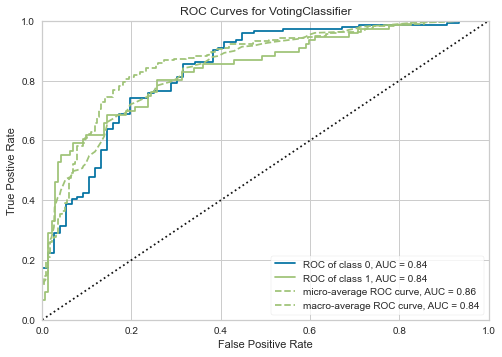

In [104]:
plot_model(blend_specific_soft)

In [119]:
# alright lets make some predictions 
predict_model(blend_specific_soft)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Voting Classifier,0.8045,0.8397,0.5921,0.7895,0.6767,0.5407


In [ ]:
# Finalizing the model

In [121]:
final_model = finalize_model(blend_specific_soft)

In [ ]:
# Moment of truth … let’s see how our classifier does if we can predict using the unseen data 

In [123]:
unseen_predictions = predict_model(final_model, data=data_unseen)
unseen_predictions

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Label,Score
0,5,116,74,0,0,25.6,0.201,30,0,0,0.0919
1,1,146,56,0,0,29.7,0.564,29,0,1,0.5897
2,7,103,66,32,0,39.1,0.344,31,1,0,0.3279
3,1,71,48,18,76,20.4,0.323,22,0,0,0.0089
4,2,107,74,30,100,33.6,0.404,23,0,0,0.1317
5,3,170,64,37,225,34.5,0.356,30,1,1,0.8249
6,6,85,78,0,0,31.2,0.382,42,0,0,0.0963
7,1,138,82,0,0,40.1,0.236,28,0,0,0.3645
8,0,108,68,20,0,27.3,0.787,32,0,0,0.4141
9,7,179,95,31,0,34.2,0.164,60,0,1,0.8250


Label and score are added to the data frame. 
•	Label is the predicted outcome 
•	Score is the predicted probability 
